### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeCV
from sklearn.metrics import hinge_loss
from sklearn.model_selection import KFold, train_test_split

from hidimstat import CPI

### Make the dataset

In [ ]:
global_random_seed = 0
rng = np.random.RandomState(global_random_seed)
X = rng.randn(500, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=global_random_seed
)

In [ ]:
x_pos = X_train[:, 0] > 0
y_pos = X_train[:, 1] > 0
(
    len(X_train[x_pos & y_pos]),
    len(X_train[~x_pos & y_pos]),
    len(X_train[x_pos & ~y_pos]),
    len(X_train[~x_pos & ~y_pos]),
)

(99, 100, 91, 110)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=global_random_seed)
clf = RandomForestClassifier(
    n_estimators=200, oob_score=True, random_state=global_random_seed
)
# Compute marginal importance using univariate models
marginal_scores = []
for i in range(X.shape[1]):
    feat_scores = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        X_train_univariate = X_train[:, i].reshape(-1, 1)
        X_test_univariate = X_test[:, i].reshape(-1, 1)

        univariate_model = clone(clf)
        univariate_model.fit(X_train_univariate, y_train)

        feat_scores.append(univariate_model.score(X_test_univariate, y_test))
    marginal_scores.append(feat_scores)

In [ ]:
CPI_importances = []
for i, (train_index, test_index) in enumerate(cv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    clf_c = clone(clf)
    clf_c.fit(X_train, y_train)

    vim = CPI(
        estimator=clf_c,
        method="predict",
        loss=hinge_loss,
        imputation_model_continuous=RidgeCV(np.logspace(-3, 3, 10)),
        n_permutations=50,
        random_state=global_random_seed,
    )
    vim.fit(X_train, y_train)
    CPI_importances.append(vim.importance(X_test, y_test)["importance"])

CPI_importances = np.array(CPI_importances).T

In [204]:
UFI_importances = []
MDIOOB_importances = []
for i, (train_index, test_index) in enumerate(cv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    clf_c = clone(clf)
    clf_c.fit(X_train, y_train)
    UFI_importances.append(clf_c.ufi_feature_importances_)
    MDIOOB_importances.append(clf_c.mdi_oob_feature_importances_)

UFI_importances = np.array(UFI_importances).T
MDIOOB_importances = np.array(MDIOOB_importances).T

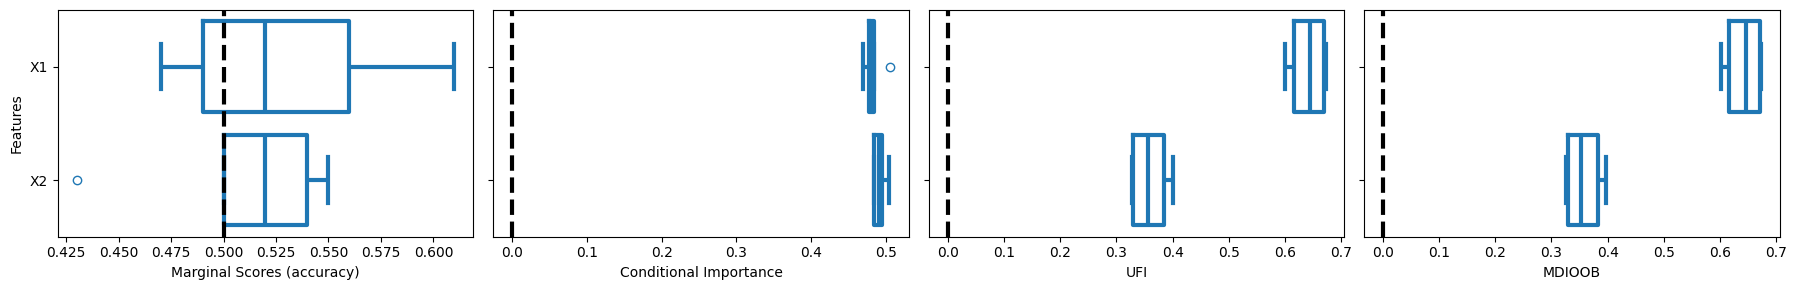

In [ ]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(18, 3))
# Marginal scores boxplot
sns.boxplot(
    data=np.array(marginal_scores).T,
    orient="h",
    ax=axes[0],
    fill=False,
    color="C0",
    linewidth=3,
)
axes[0].axvline(x=0.5, color="k", linestyle="--", lw=3)
axes[0].set_ylabel("")
axes[0].set_yticks([0, 1], ["X1", "X2"])
axes[0].set_xlabel("Marginal Scores (accuracy)")
axes[0].set_ylabel("Features")

# CPI Importances boxplot
sns.boxplot(
    data=np.array(CPI_importances).T,
    orient="h",
    ax=axes[1],
    fill=False,
    color="C0",
    linewidth=3,
)
axes[1].set_xlabel("Conditional Importance")
axes[1].axvline(x=0.0, color="k", linestyle="--", lw=3)

# UFI Importances boxplot
sns.boxplot(
    data=np.array(UFI_importances).T,
    orient="h",
    ax=axes[2],
    fill=False,
    color="C0",
    linewidth=3,
)
axes[2].set_xlabel("UFI")
axes[2].axvline(x=0.0, color="k", linestyle="--", lw=3)

# MDIOOB Importances boxplot
sns.boxplot(
    data=np.array(MDIOOB_importances).T,
    orient="h",
    ax=axes[3],
    fill=False,
    color="C0",
    linewidth=3,
)
axes[3].set_xlabel("MDIOOB")
axes[3].axvline(x=0.0, color="k", linestyle="--", lw=3)
plt.tight_layout()
plt.show()

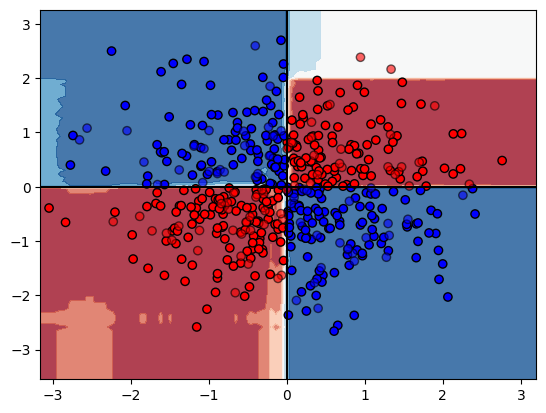

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

clf_c = clone(clf)
clf_c.fit(X_train, y_train)
disp = DecisionBoundaryDisplay.from_estimator(clf_c, X, cmap=cm, alpha=0.8, eps=0.5)

# Plot the training points
disp.ax_.scatter(
    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
)
# Plot the testing points
disp.ax_.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test,
    cmap=cm_bright,
    edgecolors="k",
    alpha=0.6,
)
disp.ax_.axvline(x=0.0, color="black")
disp.ax_.axhline(y=0.0, color="black")
